# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

---
### *Описание данных*

__*Для исследования получен csv-файл `users_behavior.csv`*__

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
* сalls — количество звонков
* minutes — суммарная длительность звонков в минутах
* messages — количество sms-сообщений
* mb_used — израсходованный интернет-трафик в Мб
* is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

## Откроем и изучим файл

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

In [2]:
#  Используем блок try - except для обработки исключений и гарантированного доступа к файлу.
#  Считаем данные из csv-файла в датафрейм и сохраним его в переменной 'data'.
try:
    df = pd.read_csv('datasets/users_behavior.csv')
except FileNotFoundError:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Преобразуем значения в столбцах к наименьшему возможному типу данных для экономии памяти.

In [5]:
for col in df.select_dtypes(include='float').columns:
    df[col] = pd.to_numeric(df[col], downcast='float')
for col in df.select_dtypes(include='integer').columns:
    df[col] = pd.to_numeric(df[col], downcast='integer')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float32
 1   minutes   3214 non-null   float32
 2   messages  3214 non-null   float32
 3   mb_used   3214 non-null   float32
 4   is_ultra  3214 non-null   int8   
dtypes: float32(4), int8(1)
memory usage: 53.5 KB


Оценим имеющиеся корреляции между признаками.

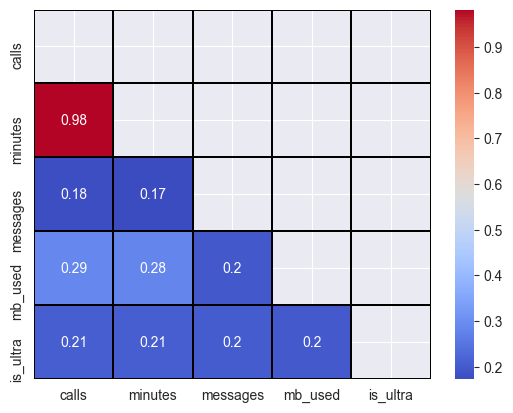

In [7]:
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, mask=matrix, cmap='coolwarm', linewidths=0.1, linecolor='black');

In [ ]:
g = sns.PairGrid(df, hue='is_ultra')
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
plt.legend(title='tariff', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

In [ ]:
g = sns.pairplot(df, hue='is_ultra',  kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})

## Разбивка данных на выборки

In [ ]:
df.is_ultra.value_counts()

Отметим, что в изначально имеющемся у нас df имеется двукратная разница по количеству имеющихся данных в пользу тарифа Smart.

In [ ]:
df_train, df_check = train_test_split(df, random_state=56, train_size=0.6, stratify=df.is_ultra)

In [ ]:
df_valid, df_test = train_test_split(df_check, random_state=56, train_size=0.5, stratify=df_check.is_ultra)
print(f"Количество строк в df_train по классам: {np.bincount(df_train.is_ultra)}",
      f"Количество строк в df_valid по классам: {np.bincount(df_valid.is_ultra)}",
      f"Количество строк в df_test по классам: {np.bincount(df_test.is_ultra)}", sep='\n')

In [ ]:
features_train, features_valid, features_test = (df_train.drop('is_ultra', axis=1),
                                                 df_valid.drop('is_ultra', axis=1),
                                                 df_test.drop('is_ultra', axis=1))
target_train, target_valid, target_test = (df_train['is_ultra'],
                                           df_valid['is_ultra'],
                                           df_test['is_ultra'])

## Исследование модели

Построим модель с использованием решающего дерева и оценим показатель accuracy для данной модели.

In [ ]:
best_accuracy_decision_tree = 0
best_model_decision_tree = None
best_depth_decision_tree = 0
best_fs_decision_tree = 0
for fs in range(1, 5):
    for depth in range(2, 5):
        model = DecisionTreeClassifier(random_state=56, max_depth=depth, max_features=fs)
        model.fit(features_train, target_train)
        predict = model.predict(features_valid)
        accuracy_decision_tree = accuracy_score(target_valid, predict)
        if accuracy_decision_tree > best_accuracy_decision_tree:
            best_accuracy_decision_tree = accuracy_decision_tree
            best_model_decision_tree = model
            best_depth_decision_tree = depth
            best_fs_decision_tree = fs
print(f'Лучший показатель точности модели решающего дерева: {best_accuracy_decision_tree}')

Построим модель с использованием логистической регрессии и оценим показатель accuracy для данной модели.

In [ ]:
model_logistic_regression = LogisticRegression(solver='lbfgs', max_iter=1000)
model_logistic_regression.fit(features_train, target_train)
predict = model_logistic_regression.predict(features_valid)
accuracy_logistic_regression = accuracy_score(target_valid, predict)
print(f'Показатель точности модели логистической регрессии: {accuracy_logistic_regression}')

Построим модель с использованием случайного леса и оценим показатель accuracy для данной модели.

In [ ]:
best_accuracy_random_forest = 0
best_model_random_forest = None
best_depth_random_forest = 0
best_fs_random_forest = 0
best_count_trees = 0
for est in range(10, 51, 10):
    for fs in range(1, 5):
        for depth in range(2, 5):
            model = RandomForestClassifier(random_state=56, max_depth=depth, max_features=fs, n_estimators=est)
            model.fit(features_train, target_train)
            predict = model.predict(features_valid)
            accuracy_random_forest = accuracy_score(target_valid, predict)
            if accuracy_random_forest > best_accuracy_random_forest:
                best_accuracy_random_forest = accuracy_random_forest
                best_model_random_forest = model
                best_depth_random_forest = depth
                best_fs_random_forest = fs
                best_count_trees = est
print(f'Лучший показатель точности модели решающего дерева: {best_accuracy_random_forest}')

## Проверка модели на тестовой выборке

Переобучим две самые сильные модели по показателю accuracy, посчитанному для каждой модели при проверке по данным для валидации.

In [ ]:
post_train_features = pd.concat([features_train, features_valid], ignore_index=True)
post_train_target = pd.concat([target_train, target_valid], ignore_index=True)

In [ ]:
post_train_features.to_csv('e1eeeeeeee.csv', index=False)

In [ ]:
model_decision_tree = DecisionTreeClassifier(random_state=56, max_depth=best_depth_decision_tree, max_features=best_fs_decision_tree)
model_decision_tree.fit(post_train_features, post_train_target);

In [ ]:
model_random_forest = RandomForestClassifier(random_state=56, max_depth=best_depth_random_forest, max_features=best_fs_random_forest, n_estimators=best_count_trees)
model_random_forest.fit(post_train_features, post_train_target);
test15 = 'model.joblib'
dump(model_random_forest, 'test15.joblib')

Проверим модели в порядке убывания их точности, показанной на проверке по данным для валидации.

In [ ]:
t_dict = {model_random_forest: 'случайного леса', model_decision_tree: 'решающего дерева'}

for ml in t_dict:
    predict = ml.predict(features_test)
    print(f'Точность предсказания модели {t_dict[ml]} на тестовых данных: {accuracy_score(target_test, predict)}')

Делаем вывод, что две модели преодолели порог в 0.75 пунктов точности прогноза или 75%.

##  Проверка модели на адекватность

Создадим объект series размером с выборку для теста и заполним его самым распространенным значением - 0.

In [ ]:
target_predict_constant = pd.Series([0] * len(target_test))
print(f'accuracy_score константой модели: {accuracy_score(target_test, target_predict_constant)}')

Делаем вывод, что две наши модели прошли проверку на адекватность, так как вычисленный параметр accuracy у обеих моделей превышает показатель константной модели - равный ~ 0.693.

---
### *Проверка моделей на скорость исполнения при прогнозировании*

In [ ]:
df.shape[0]

Проверим скорость прогнозирования на исходном размере нашего df.

In [ ]:
%timeit best_model_random_forest.predict(df.drop('is_ultra', axis=1))

In [ ]:
%timeit best_model_decision_tree.predict(df.drop('is_ultra', axis=1))

Ожидаемо получаем, что решающее дерево дает прогнозы быстрее и с увеличением размера df разница будет увеличиваться экспоненциально.

---
### *Проверка моделей на скорость обучения*

In [ ]:
%%timeit
model_decision_tree = DecisionTreeClassifier(random_state=56, max_depth=best_depth_decision_tree, max_features=best_fs_decision_tree)
model_decision_tree.fit(post_train_features, post_train_target);

In [ ]:
%%timeit
model_random_forest = RandomForestClassifier(random_state=56, max_depth=best_depth_random_forest, max_features=best_fs_random_forest, n_estimators=best_count_trees)
model_random_forest.fit(post_train_features, post_train_target);

Ожидаемо получаем, что решающее дерево обучается быстрее, так как оно одно, а в случайном лесу в нашей наилучшей модели – 40 деревьев.

---
## Общий вывод по исследованию

<div style="border:solid orange 2px; padding: 5px">

<div class="alert alert-info"> <b>При проведении исследования (на основе полученных данных) выполнено:</b></div>

- Данные разделены на 3 части: для обучения моделей, для валидации и данные для проведения финального тестирования в соотношении 60 - 20 - 20 соответственно.
- Проведено обучение моделей трех различных типов: решающего дерева, логистической регрессии и случайного леса.
- Модель решающего дерева и модель случайного леса преодолели порог в 0.75 пунктов точности, показав результаты 0.79 и 0.8 соответственно.
- Перед проведением финального тестирования данные для первичной тренировки и данные для валидации объединены в один df для переобучения избранных моделей на большем объеме данных.
- Проведена проверка моделей на тестовой выборке. Показатель accuracy для модели решающего дерева составил - 0.811, а для модели случайного леса - 0.822.
- Модели проверены на адекватность, сделан вывод об адекватности моделей.
- Модели оценены на скорость исполнения при прогнозировании. Убедились в том, что решающее дерево дает прогнозы быстрее и с увеличением размера df разница будет увеличиваться экспоненциально.
- Модели оценены на скорость обучения. Убедились в том, что решающее дерево обучается быстрее по определению, так как оно одно, а в случайном лесу в нашей наилучшей модели – 40 деревьев.
